In [1]:
import torch
import numpy as np
import mazelab
import matplotlib.pyplot as plt 
import cv2

In [2]:
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
from mazelab.solvers.dijkstra_solver import dijkstra_solver, dijkstra_solver_full

In [4]:
from rl_trickery.envs.maze import generate_random, MazelabEnv, Maze
from rl_trickery.envs.wrappers import ResizeImage, TransposeImage

In [5]:
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset, Dataset

# Generate mazes

Generate maze, set goal, find solutions, store all.

In [6]:
maze_size = 9 
env = MazelabEnv(maze_size=maze_size, maze_kind="maze", goal_fixed=False, maze_fixed=False, goal_reward=False, wall_reward=False)
env = ResizeImage(env, (64, 64), antialias=True)
env = TransposeImage(env)

5


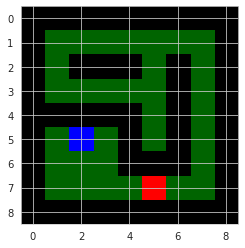

In [7]:
im = env.unwrapped.reset()
# im = env.get_image()
plt.imshow(im)
print(env.get_distance_to_goal())

In [8]:
def generate_dataset(env, n):
    X = []
    Y = []
    for i in range(int(n)):
        x = env.reset()
        y = env.get_distance_matrix()
        X.append(torch.IntTensor(x))
        Y.append(torch.IntTensor([y]))
        
    Y = torch.stack(Y)
    X = torch.stack(X)
    ds = TensorDataset(X, Y)    
    return ds

# Alternative data generation

In [9]:
from rl_trickery.envs.maze import generate_random, MazelabEnv

In [10]:
class MazeDataset(Dataset):
    def __init__(self, boards, distances, goals):
        super(MazeDataset, self).__init__()
        self.boards = boards
        self.distances = distances
        self.goals = goals

    def __len__(self):
        return len(self.boards)
        
    def __getitem__(self, index):
        board = self.boards[index]
        distances = self.distances[index]
        goal = self.goals[index]

        m = Maze().from_numpy(board)        
        m.make_objects()
        m.goal = goal
        m.objects.goal.positions = goal
        m.objects.agent.positions = m.randomize_agent()
        pos_x, pos_y = m.objects.agent.positions.T
        
        
        image = m.to_rgb()
        image = self.add_padding(image)
        image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_NEAREST)
        image = image.transpose(2, 0, 1)
        image = torch.FloatTensor(image)/255
        
        
        y = torch.FloatTensor(distances[pos_x, pos_y])
        
        return image, y
        
        
    def add_padding(self, image):
        paddings = []
        for old_size in image.shape[0:2]:
            full_padding = 2 ** np.ceil(np.log2(old_size)) - old_size
            start_padding = int(np.floor(full_padding/2))
            end_padding = int(np.ceil(full_padding/2))
            paddings.append(start_padding)
            paddings.append(end_padding)

        if any(paddings):
            image = cv2.copyMakeBorder(image, *paddings, cv2.BORDER_CONSTANT, value=(0, 0, 0))
        return image


In [11]:
maze_size = 7
env = MazelabEnv(maze_size=maze_size, maze_kind="maze", goal_fixed=False, maze_fixed=False, goal_reward=False, wall_reward=False)
env = ResizeImage(env, (64, 64), antialias=True)
env = TransposeImage(env)
im = env.unwrapped.reset();

2


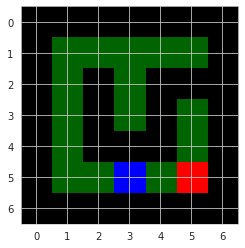

In [12]:
plt.imshow(im)
print(env.get_distance_to_goal())

In [13]:
board = env.unwrapped.maze.board
board

array([[1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 1, 1, 1],
       [1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1]])

In [14]:
distances = env.get_distance_matrix().reshape((maze_size, maze_size))
distances

array([[-1., -1., -1., -1., -1., -1., -1.],
       [-1.,  8.,  9., 10., 11., 12., -1.],
       [-1.,  7., -1., 11., -1., -1., -1.],
       [-1.,  6., -1., 12., -1.,  2., -1.],
       [-1.,  5., -1., -1., -1.,  1., -1.],
       [-1.,  4.,  3.,  2.,  1.,  0., -1.],
       [-1., -1., -1., -1., -1., -1., -1.]])

In [15]:
goal = env.unwrapped.maze.goal
goal

array([[5, 5]])

In [16]:
m = Maze().from_numpy(board)

In [17]:
m.board

array([[1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 1, 1, 1],
       [1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1]])

[11.]


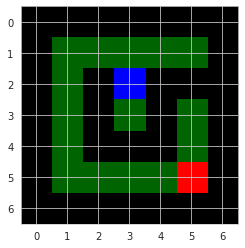

In [18]:
m.make_objects()
m.goal = goal
m.objects.goal.positions = goal
m.objects.agent.positions = m.randomize_agent()
pos_x, pos_y = m.objects.agent.positions.T
plt.imshow(m.to_rgb())
print(distances[pos_x, pos_y])

In [19]:
def generate_dataset(env, n):
    boards = []
    distances = []
    goals = []
    for i in range(int(n)):
        x = env.reset()
        boards.append(torch.IntTensor(env.unwrapped.maze.board))
        distances.append(torch.IntTensor(env.get_distance_matrix().reshape((maze_size, maze_size))))
        goals.append(torch.IntTensor(env.unwrapped.maze.goal))
        
    boards = np.stack(boards)
    distances = np.stack(distances)
    goals = np.stack(goals)
    ds = MazeDataset(boards, distances, goals) 
    
    return ds

In [20]:
env = MazelabEnv(
    maze_size=maze_size, maze_kind="maze",
    goal_fixed=False, maze_fixed=False, goal_reward=False, wall_reward=False
)
ds = generate_dataset(env, 10)

In [21]:
ds[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([2.]))

# Load mazes

Load maze, to pixels, scale image up, to pytorch, generate target variable

In [32]:
BATCH_SIZE = 8
maze_size = 15
env = MazelabEnv(maze_size=maze_size, maze_kind="maze", goal_fixed=False, maze_fixed=False, goal_reward=False, wall_reward=False)
env = ResizeImage(env, (64, 64), antialias=True)
env = TransposeImage(env)

dl_train = DataLoader(
    generate_dataset(env, 1e4),
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    drop_last=True
)
dl_test = DataLoader(
    generate_dataset(env, 1e3),
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    drop_last=True
)

# Init networks

Define models, init

In [33]:
from rl_trickery.models.tricky_policy_networks import *

In [34]:

class MazeSolver(nn.Module):
    def __init__(
            self,
            obs_space,
            architecture,
            state_channels=32,
            hidden_size=128,
            fixed_recursive_depth=1,
            append_coords=False,
            pool_and_inject=False,
            skip_connection=False,
    ):
        super(MazeSolver, self).__init__()
        
        init_relu = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.constant_(x, 0),
                           nn.init.calculate_gain('relu'))

        self.hidden_size = hidden_size
        self.architecture = architecture
        self.is_recurrent = architecture in ["rnn", "crnn"]
        self.spatial_state_shape = (7, 7) if architecture == "crnn" else ()  # dictated by layer choice in encoder

        self.encoder = Encoder(obs_space, hidden_size, state_channels, append_coords=append_coords)

        if architecture == "ff":
            self.transition = NoTransition(hidden_size)
        elif architecture == "rnn":
            self.transition = RNNTransition(
                hidden_size=hidden_size,
                recurse_depth=fixed_recursive_depth,
                skip_connection=skip_connection,
            )
        elif architecture == "crnn":
            self.transition = CRNNTransition(
                state_channels=state_channels,
                spatial_shape=self.spatial_state_shape,
                recurse_depth=fixed_recursive_depth,
                append_coords=append_coords,
                pool_inject=pool_and_inject,
                skip_connection=skip_connection,
            )
        else:
            raise NotImplementedError

        self.enc2trans = DimensionalityAdjuster(
            in_shape=self.encoder.out_shape,
            out_shape=self.transition.in_shape
        )

        self.trans2ac = DimensionalityAdjuster(
            in_shape=self.transition.out_shape,
            out_shape=np.array((hidden_size,))
        )
        
        self.lin_out = nn.Sequential(
            init_relu(nn.Linear(hidden_size, 1,)),
        )

        self.train()
    
    def recurrent_hidden_state_size(self):
        if self.is_recurrent:
            return self.transition.recurrent_hidden_state_size
        else:
            return (0,)
        
    def forward(self, obs, rnn_h, done):
        x = self.encoder(obs)
        x_enc = self.enc2trans(x)
        x_trans, rnn_h = self.transition(x_enc, rnn_h, done, None)
        x_ac = self.trans2ac(x_trans)
        out = self.lin_out(x_ac)
        return out, rnn_h


In [46]:
net = MazeSolver(
    env.observation_space,
    architecture="ff",
    fixed_recursive_depth=1,
    append_coords=False,
    skip_connection=False,
).cuda()

In [47]:
opt = torch.optim.Adam(net.parameters(), lr=0.001)

In [49]:
EPOCHS = 50

rnn_h = torch.zeros((BATCH_SIZE,) + net.recurrent_hidden_state_size()).to("cuda")
done = torch.ones((BATCH_SIZE, 1)).to("cuda")

for i_epoch in range(EPOCHS):
    total_loss = 0
    for i_batch, data in enumerate(dl_train):
        net.zero_grad()
        
        x, y = data
        y = y.cuda()

        y_hat, rnn_h = net(x.cuda(), rnn_h.detach(), done)
        loss = F.smooth_l1_loss(y_hat, y)
        loss.backward()
        opt.step()
        total_loss += loss
    total_loss /= i_batch+1
        
            
    with torch.no_grad():
        test_loss = 0
        for i_batch, data in enumerate(dl_test):
            x, y = data
            y = y.cuda()
            

            y_hat, _ = net(x.cuda(), rnn_h, done)
            test_loss += F.smooth_l1_loss(y_hat, y)

        test_loss /= i_batch+1
        test_loss
    
    print("epoch", i_epoch)
    print("train", total_loss.item())
    print("test", test_loss.item())
    print("var", (y_hat.var()/y.var()).item())


epoch 0
train 5.987203598022461
test 5.977117538452148
var 1.2237468638431892e-07
epoch 1
train 5.934103488922119
test 5.842068195343018
var 9.112365262353705e-08
epoch 2
train 6.030841827392578
test 5.898318290710449
var 8.271213935984179e-09
epoch 3
train 5.964996814727783
test 6.197321891784668
var 1.5288458277140649e-09
epoch 4
train 5.997155666351318
test 5.865070819854736
var 2.2259143245511974e-14
epoch 5
train 5.995581150054932
test 5.943775653839111
var 0.0
epoch 6
train 5.883892059326172
test 6.150460720062256
var 1.6391906956141414e-14
epoch 7
train 5.966612815856934
test 6.04671573638916
var 3.250009175627053e-14
epoch 8
train 5.954584121704102
test 6.127868175506592
var 6.705951711896002e-14
epoch 9
train 5.905113697052002
test 6.063603401184082
var 0.0
epoch 10
train 5.967709064483643
test 6.276136875152588
var 0.0
epoch 11
train 6.051307678222656
test 6.148240089416504
var 2.6058270667130012e-14
epoch 12
train 5.933767318725586
test 6.009316921234131
var 2.31810674578307

KeyboardInterrupt: 

In [ ]:
test_loss = 0
for i_batch, data in enumerate(dl_test):
    x, y = data

    y_hat, _ = net.cpu()(x, rnn_h.cpu().detach(), done.cpu())
    test_loss += F.smooth_l1_loss(y_hat, y)
    
test_loss /= i_batch+1
test_loss

In [ ]:
i = 0

In [ ]:
idx = ((y - y_hat)**2).argmax()
im = x.cpu().numpy()[idx].transpose([1, 2, 0])
plt.imshow(im)
print(y[idx])
print(y_hat[idx])


In [ ]:
i += 1
im = x.cpu().numpy()[i].transpose([1, 2, 0])
plt.imshow(im)
print(y_hat[i], y[i])

In [ ]:
torch.cat([y_hat, y, (y - y_hat)], axis=1).detach().cpu().numpy()

In [ ]:
y_hat.var()

In [ ]:
y.var()

In [31]:

loss.item()

6.312914848327637

In [29]:
dir(loss)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__cuda_array_interface__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ilshift__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rfloordiv__',
 '__rmul__',
 '__rpow__',
 '__rshift__',
 '__rsub__',
 '__rtrued